In [2]:
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn
import torch
import torchvision.transforms as transforms

# Config
LEARNING_RATE = 0.01
BATCH_SIZE = 64
HIDDEN1 = 300
HIDDEN2 = 200

### Read Data

In [3]:
import pandas as pd

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Preprocess

In [4]:
train_set = train.drop(columns=["Name", "PassengerId", "Ticket"])
test_set = test.drop(columns=["Name", "PassengerId", "Ticket"])

print("==========Embarked==========")
print(train_set["Embarked"].value_counts(dropna=False))
print("============================")
print(test_set["Embarked"].value_counts(dropna=False))
# print(train_set["Embarked"].nunique())
print("===========Sex==============")
print(train_set["Sex"].value_counts(dropna=False))
print("============================")
print(test_set["Sex"].value_counts(dropna=False))
print("===========Cabin============")
print(train_set["Cabin"].value_counts(dropna=False))
print("============================")
print(test_set["Cabin"].value_counts(dropna=False))



==========Embarked==========
Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64
Embarked
S    270
C    102
Q     46
Name: count, dtype: int64
===========Sex==============
Sex
male      577
female    314
Name: count, dtype: int64
Sex
male      266
female    152
Name: count, dtype: int64
===========Cabin============
Cabin
NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64
Cabin
NaN                327
B57 B59 B63 B66      3
C89                  2
C116                 2
C80                  2
                  ... 
E45                  1
E52                  1
B58 B60              1
C62 C64              1
C105                 1
Name: count, Length: 77, dtype: int64


In [5]:
train_set.dropna(subset=["Embarked"])

train_set.drop(columns="Cabin", inplace=True)
test_set.drop(columns="Cabin", inplace=True)

mapping_Embarked = {
    'S': 1,
    'C': 2,
    'Q': 3
}

mapping_sex = {
    'male': 1,
    'female': 2,
}

train_set["Embarked"] = train_set["Embarked"].replace(mapping_Embarked)
test_set["Embarked"] = test_set["Embarked"].replace(mapping_Embarked)
train_set["Sex"] = train_set["Sex"].replace(mapping_sex)
test_set["Sex"] = test_set["Sex"].replace(mapping_sex)

train_set = train_set.fillna(0)
test_set = test_set.fillna(0)

train_set.head()


C:\Users\LiYan\AppData\Local\Temp\ipykernel_25120\4043371184.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_set["Embarked"] = train_set["Embarked"].replace(mapping_Embarked)
C:\Users\LiYan\AppData\Local\Temp\ipykernel_25120\4043371184.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_set["Embarked"] = test_set["Embarked"].replace(mapping_Embarked)
C:\Users\LiYan\AppData\Local\Temp\ipykernel_25120\4043371184.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future ver

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,1.0
1,1,1,2,38.0,1,0,71.2833,2.0
2,1,3,2,26.0,0,0,7.9250,1.0
3,1,1,2,35.0,1,0,53.1000,1.0
4,0,3,1,35.0,0,0,8.0500,1.0


In [6]:
train_set.shape

(891, 8)

In [7]:
train_set.iloc[:, :1].head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [8]:
class MyNN(nn.Module):
    def __init__(self) -> None:
        super(MyNN, self).__init__()
        self.input_to_hidden1 = nn.Linear(7, HIDDEN1)
        self.hidden1_to_hidden2 = nn.Linear(HIDDEN1, HIDDEN2)
        self.hidden2_to_output = nn.Linear(HIDDEN2, 2)

    def forward(self, x):
        x = F.relu(self.input_to_hidden1(x))
        x = F.relu(self.hidden1_to_hidden2(x))
        x = self.hidden2_to_output(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [10]:
X = train_set.drop(columns=['Survived']).values  # 假设 'Survived' 是目标列
y = train_set['Survived'].values  # 目标列

print(X[:5])
print("==================================")
print(y[:5])

[[ 3.      1.     22.      1.      0.      7.25    1.    ]
 [ 1.      2.     38.      1.      0.     71.2833  2.    ]
 [ 3.      2.     26.      0.      0.      7.925   1.    ]
 [ 1.      2.     35.      1.      0.     53.1     1.    ]
 [ 3.      1.     35.      0.      0.      8.05    1.    ]]
[0 1 1 1 0]


In [11]:
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.long).to(device)

In [12]:
from torch.utils.data import DataLoader, TensorDataset

# 创建数据集和数据加载器
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # 可以调整批量大小

In [13]:
import torch.optim as optim

model = MyNN().to(device)
criterion = nn.CrossEntropyLoss()  # 适用于分类任务
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 可以调整学习率

Loss_lis = list()

# 训练模型
num_epochs = 100  # 可以调整训练轮数
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()  # 清除之前的梯度
        outputs = model(batch_X)  # 前向传播
        loss = criterion(outputs, batch_y)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
    Loss_lis.append(loss.item())

print('训练完成')

Epoch 1/100, Loss: 1.3077
Epoch 2/100, Loss: 0.7791
Epoch 3/100, Loss: 0.6598
Epoch 4/100, Loss: 0.7089
Epoch 5/100, Loss: 0.6792
Epoch 6/100, Loss: 0.5658
Epoch 7/100, Loss: 0.5004
Epoch 8/100, Loss: 0.6218
Epoch 9/100, Loss: 0.5454
Epoch 10/100, Loss: 0.8656
Epoch 11/100, Loss: 0.5838
Epoch 12/100, Loss: 0.5149
Epoch 13/100, Loss: 0.5728
Epoch 14/100, Loss: 0.5558
Epoch 15/100, Loss: 0.5151
Epoch 16/100, Loss: 0.4667
Epoch 17/100, Loss: 0.4645
Epoch 18/100, Loss: 0.3225
Epoch 19/100, Loss: 0.5019
Epoch 20/100, Loss: 0.6392
Epoch 21/100, Loss: 0.3824
Epoch 22/100, Loss: 0.9429
Epoch 23/100, Loss: 0.3925
Epoch 24/100, Loss: 0.4441
Epoch 25/100, Loss: 0.4951
Epoch 26/100, Loss: 0.5068
Epoch 27/100, Loss: 0.4834
Epoch 28/100, Loss: 0.5235
Epoch 29/100, Loss: 0.5290
Epoch 30/100, Loss: 0.4221
Epoch 31/100, Loss: 0.6618
Epoch 32/100, Loss: 0.3792
Epoch 33/100, Loss: 0.7065
Epoch 34/100, Loss: 0.3672
Epoch 35/100, Loss: 0.4369
Epoch 36/100, Loss: 0.7048
Epoch 37/100, Loss: 0.5648
Epoch 38/1

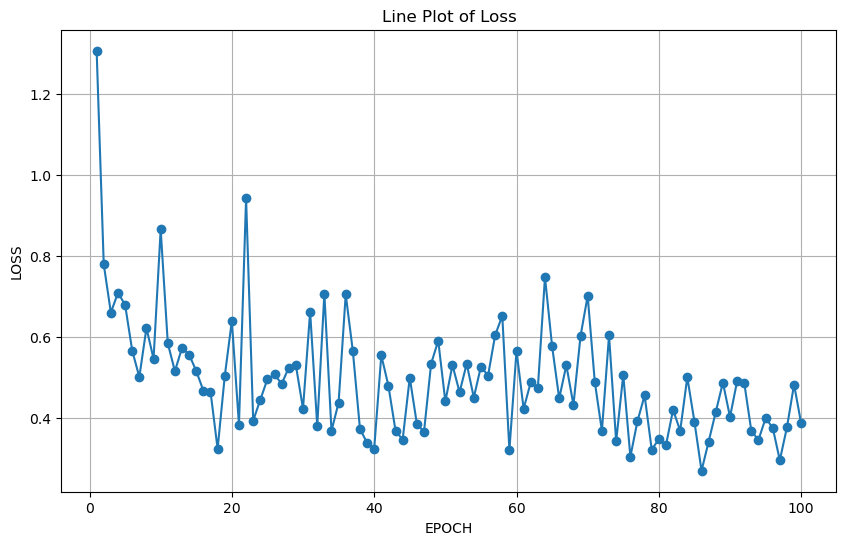

In [14]:
import matplotlib.pyplot as plt


# 横坐标为 1 到 100
x_values = list(range(1, 101))

# 创建一个折线图
plt.figure(figsize=(10, 6))
plt.plot(x_values, Loss_lis, marker='o')

# 添加标题和标签
plt.title('Line Plot of Loss')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()


In [16]:
save_path = './line_plot.png'  # 替换为你的实际路径
plt.savefig(save_path)

<Figure size 640x480 with 0 Axes>